# Master's thesis case study 2: Variable Covariates

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy
import torch
from adaptive_nof1 import *
from adaptive_nof1.policies import *
from adaptive_nof1.helpers import *
from adaptive_nof1.inference import *
from adaptive_nof1.metrics import *
from matplotlib import pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Linear Predictor

In [17]:
# Setup generic n-of-1 parameters
length = 30
number_of_actions = 5
number_of_patients = 1
block_length = 1

In [18]:
# In this case study, we assume a linear predictor for the outcome
# Outcome = (a_x + c * b_x) (a,b parameters, c covariate, X treatment)
# Our data generating model can therefore be expressed as a multivariate normal with \eye as the covariance matrics
class LinearPredictorModel(Model):
    def __init__(self, patient_id):
        self.rng = numpy.random.default_rng(patient_id)
        self.a = self.rng.normal(0, 1, size=number_of_actions)
        self.b = self.rng.normal(0, 1, size=number_of_actions)
        self.patient_id = patient_id

    @property
    def additional_config(self):
        return {"expectations_of_interventions": self.mu}
 
    def generate_context(self, history):
        return { "c": self.rng.normal(0, 1) }

    def observe_outcome(self, intervention, context):
        intervention_index = intervention["treatment"]
        a = self.a[intervention_index]
        b = self.b[intervention_index]
        return {"outcome": self.rng.normal(a + context["c"] * b, 1)}

    def __str__(self):
        return f"LinearPredictorModel"

data_generating_model = lambda patient_id: LinearPredictorModel(patient_id)

In [64]:
class LinearPredictorInference(BayesianModel):
    def __str__(self):
        return f"LinearPredictorInference"
    
    def update_posterior(self, history, number_of_treatments):
        df = history.to_df()

        if len(df) == 0:
            return

        self.model = pymc.Model()
        with self.model:
            treatment_index = pymc.MutableData("treatment_index", pymc.intX(df[self.treatment_name]), dims="observation")
            a = pymc.Normal("a", mu=0, sigma=1, dims="treatment", shape=number_of_treatments)
            b = pymc.Normal("b", mu=0, sigma=1, dims="treatment", shape=number_of_treatments)
            c = pymc.MutableData("c", pymc.floatX(df["c"]), dims="observation")
            outcome = pymc.Normal(
                "outcome", mu=a[treatment_index] + b[treatment_index] * c, observed=df["outcome"], sigma=1, dims="observation",
            )
            self.trace = pymc.sample(2000, progressbar=False)

    def approximate_max_probabilities(self, number_of_treatments, context):
        if context["t"] == 0:
            return [0.5, 0.5]
        assert (
            self.trace is not None
        ), "You called `approximate_max_probabilites` without updating the posterior"

        with self.model:
            pymc.set_data(
                {
                    "treatment_index": pymc.intX(range(number_of_treatments)),
                    "c": pymc.floatX([context["c"]] * number_of_treatments),
                }
            )
            trace = pymc.sample_posterior_predictive(self.trace, var_names=["outcome"])
            max_indices = np.ravel(
                trace.posterior_predictive["outcome"].argmax(
                    dim="observation"
                )
            )
        bin_counts = np.bincount(max_indices, minlength=number_of_treatments)
        return bin_counts / np.sum(bin_counts)

In [65]:
# Inference Model
inference_model = lambda: LinearPredictorInference()

In [66]:
# Policies

fixed_policy = BlockPolicy(
        block_length = block_length,
        internal_policy = FixedPolicy(
        number_of_actions=number_of_actions,
        inference_model = inference_model(),
    ),
)


thompson_sampling_policy = BlockPolicy(
            block_length = block_length,
            internal_policy = ThompsonSampling(
                inference_model=inference_model(),
                number_of_actions=number_of_actions,
            ),
)

ucb_policy = BlockPolicy(
        block_length = block_length,
        internal_policy = UpperConfidenceBound(
            inference_model=inference_model(),
            number_of_actions=number_of_actions,
            epsilon=0.05,
        ),
)

In [67]:
# Full crossover study
study_designs = {
    "n_patients": [number_of_patients],
    "policy": [fixed_policy, thompson_sampling_policy, ucb_policy],
    #"model_from_patient_id": [
    #    generating_scenario_I, generating_scenario_II, generating_scenario_III, generating_scenario_IV, generating_scenario_V,
    #],
    "model_from_patient_id": [
        data_generating_model,
    ]
}
configurations = generate_configuration_cross_product(study_designs)

In [68]:
calculated_series, config_to_simulation_data = simulate_configurations(
    configurations, length
)

  0%|          | 0/30 [00:00<?, ?it/s]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [outcome]


AttributeError: 'LinearPredictorModel' object has no attribute 'mu'

In [28]:
metrics = [
    SimpleRegretWithMean(),
    CumulativeRegret(),
    #KLDivergence(true_distribution = MultivariateNormal(0).distribution, debug_data_to_distribution=debug_data_to_torch_distribution)
]
model_mapping = {
    "LinearPredictorInference": "Scenario I",
}
policy_mapping = {
    "StoppingPolicy(BlockPolicy(FixedPolicy))": "Fixed",
    "StoppingPolicy(BlockPolicy(ThompsonSampling(NormalKnownVariance(0, 1, 1))))": "Thompson Sampling",
    "StoppingPolicy(BlockPolicy(UpperConfidenceBound: 0.05 epsilon))": "Upper Confidence Bounds",
}

df = SeriesOfSimulationsData.score_data(
    [s["result"] for s in calculated_series], metrics, {"model": lambda x: model_mapping[x], "policy": lambda x: policy_mapping[x]}
)
filtered_df = df.loc[df["t"] == df["t"].max()]
filtered_df

groupby_columns = ["model", "policy"]
pivoted_df = filtered_df.pivot(
    index=["model", "policy", "simulation", "patient_id"],
    columns="metric",
    values="score",
)
table = pivoted_df.groupby(groupby_columns).agg(['mean', 'std'])

table

metric                        Cumulative Regret     Simple Regret With Mean  \
                                           mean std                    mean   
model       policy                                                            
Scenario II Thompson Sampling       -105.738559 NaN                     0.0   

metric                             
                              std  
model       policy                 
Scenario II Thompson Sampling NaN

In [29]:
with open('mt_resources/6-covariates/01-table.tex', 'w') as file:
    file.write(table.style.format(precision=2).to_latex())

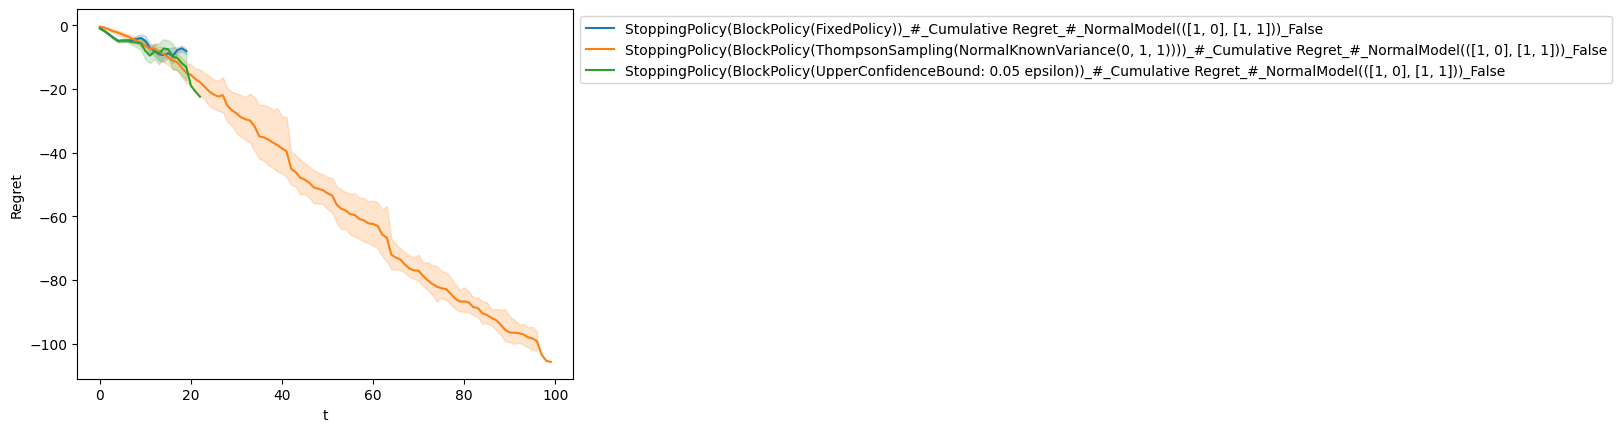

In [31]:
SeriesOfSimulationsData.plot_lines(
    [s["result"] for s in calculated_series if s["configuration"]["model"] == "NormalModel(([1, 0], [1, 1]))"],
    [
        CumulativeRegret(),
        #KLDivergence(true_distribution = MultivariateNormal(0).distribution, debug_data_to_distribution=debug_data_to_torch_distribution)
    ],
    legend_position=(1,1),
)
plt.savefig("mt_resources/6-covariates/01_cumulative_regret.pdf", bbox_inches="tight")

In [139]:
plot_allocations_for_calculated_series(calculated_series)

NameError: name 'calculated_series' is not defined

## Linear Predictor with additional target (reducing dose)

In [89]:
# Setup generic n-of-1 parameters
length = 5
number_of_actions = 5
number_of_patients = 1
block_length = 1

In [90]:
# Data Generating Model
# In this case study, we assume a log-linear regression
# log(Outcome) = c - x * a
# (Think of c as pain and x as the pill, and a as how effective the pill is)
class LogLinearModel(Model):
    def __init__(self, patient_id):
        self.rng = numpy.random.default_rng(patient_id)
        self.a = self.rng.uniform(1, 3)
        self.patient_id = patient_id

    @property
    def additional_config(self):
        return {}
 
    def generate_context(self, history):
        return { "c": self.rng.normal(0, 1) }

    def observe_outcome(self, intervention, context):
        intervention_index = intervention["treatment"]
        return {"outcome": self.rng.normal(numpy.exp(context["c"] - self.a * intervention_index), 1)}

    def __str__(self):
        return f"LogLinearModel"

data_generating_model = lambda patient_id: LogLinearModel(patient_id)

In [135]:
# Inference Model
class LogLinearInference(BayesianModel):
    def __str__(self):
        return f"LogLinearInference"
    
    def update_posterior(self, history, number_of_treatments):
        df = history.to_df()
        if len(df) == 0:
            df["c"] = []
            df["outcome"] = []

        self.model = pymc.Model()
        with self.model:
            treatment_index = pymc.MutableData("treatment_index", pymc.floatX(df[self.treatment_name]), dims="observation")
            a = pymc.Uniform("a", lower=1, upper=5)
            c = pymc.MutableData("c", pymc.floatX(df["c"]), dims="observation")
            outcome = pymc.Normal(
                "outcome", mu=numpy.exp(c - a * treatment_index), observed=df["outcome"], sigma=1, dims="observation",
            )
            self.trace = pymc.sample(2000, progressbar=False)

    def approximate_max_probabilities(self, number_of_treatments, context):
        if context["t"] == 0:
            return [0.5] * number_of_treatments
        assert (
            self.trace is not None
        ), "You called `approximate_max_probabilites` without updating the posterior"

        with self.model:
            pymc.set_data(
                {
                    "treatment_index": pymc.floatX(range(number_of_treatments)),
                    "c": pymc.floatX([context["c"]] * number_of_treatments),
                }
            )
            trace = pymc.sample_posterior_predictive(self.trace, var_names=["outcome"])
            max_indices = np.ravel(
                trace.posterior_predictive["outcome"].argmax(
                    dim="observation"
                )
            )
        bin_counts = np.bincount(max_indices, minlength=number_of_treatments)
        return bin_counts / np.sum(bin_counts)
        


In [136]:
# Policies
thompson_sampling_policy = BlockPolicy(
            block_length = block_length,
            internal_policy = ThompsonSampling(
                inference_model=LogLinearInference(),
                number_of_actions=number_of_actions,
            ),
)

ucb_policy = BlockPolicy(
        block_length = block_length,
        internal_policy = UpperConfidenceBound(
            inference_model=LogLinearInference(),
            number_of_actions=number_of_actions,
            epsilon=0.05,
        ),
)

In [137]:
# Full crossover study
study_designs = {
    "n_patients": [number_of_patients],
    "policy": [thompson_sampling_policy, ucb_policy],
    #"model_from_patient_id": [
    #    generating_scenario_I, generating_scenario_II, generating_scenario_III, generating_scenario_IV, generating_scenario_V,
    #],
    "model_from_patient_id": [
        data_generating_model,
    ]
}
configurations = generate_configuration_cross_product(study_designs)

In [138]:
calculated_series, config_to_simulation_data = simulate_configurations(
    configurations, length
)

  0%|          | 0/5 [00:00<?, ?it/s]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [outcome]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [outcome]


  0%|          | 0/5 [00:00<?, ?it/s]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


KeyError: "var names: '[5] are not present' in dataset"

In [ ]:
plot_allocations_for_calculated_series(calculated_series)